In [4]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
import gc
import pandas as pd
import numpy as np
path = "/home/ubuntu/.kaggle/competitions/home-credit-default-risk/"


params = {
         'boosting_type': 'gbdt',
          'max_depth': -1,
          'objective': 'binary',
          'n_estimators': 3485, 
          'nthread': 5,
          'num_leaves': 39,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 0.36,
          'subsample_freq': 1,
          'colsample_bytree': 0.98,
          'reg_alpha': 8,
          'reg_lambda': 2,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class': 1,
          'metric': 'auc'}

In [2]:
#Great snippet from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
        #    df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
    
    
    
    

In [ ]:
train = reduce_mem_usage(pd.read_csv(path + "application_train.csv"))
test = reduce_mem_usage(pd.read_csv(path + "application_test.csv"))
test.loc[:, "is_test"] = True

alldata = pd.concat([train, test], axis=0)
alldata.loc[:, "is_test"] = alldata.loc[:, "is_test"].fillna(False)

num_cols = alldata.select_dtypes(exclude=["object"]).columns
num_cols = [col for col in num_cols if col not in ["SK_ID_CURR", "is_test", "TARGET"]]

del train, test; gc.collect()


bureau_balance = reduce_mem_usage(pd.read_csv(path + "bureau_balance.csv"))
bureau =  reduce_mem_usage(pd.read_csv(path + 'bureau.csv'))
full_bureau = pd.merge(bureau, bureau_balance, on="SK_ID_BUREAU", how="left")

del bureau_balance, bureau
gc.collect()

dataframes = [
    (
        "previous_application",  
        "SK_ID_PREV", 
        reduce_mem_usage(pd.read_csv(path + 'previous_application.csv'))
    ),
    (
        "bureau", 
        "SK_ID_BUREAU",
        full_bureau
    ),
    (
        "POS_CASH_balance",
        "SK_ID_PREV",
        reduce_mem_usage(pd.read_csv(path + "POS_CASH_balance.csv"))
    ),
    (
        "credit_card_balance",
        "SK_ID_PREV",
        reduce_mem_usage(pd.read_csv(path + "credit_card_balance.csv"))
    ),
    (
        "installments_payments",
        "SK_ID_PREV",
        reduce_mem_usage(pd.read_csv(path + "installments_payments.csv"))
    )
]


for name, key, df in dataframes:
    print("Working on %s..." % name, end="")
    cat_cols = df.select_dtypes(include=["object"]).columns
    
    df = pd.get_dummies(
        df, 
        columns=cat_cols, 
        drop_first=True, 
        dummy_na=True
    )
    
    tmp_df_mean = df.groupby("SK_ID_CURR").agg(["mean", "max"]).drop(key, axis=1)
    tmp_df_mean.columns = ["_".join(col) for col in tmp_df_mean.columns.ravel()]
    #tmp_df_mean.loc[:, "%s_count"%name] = df.loc[:, "SK_ID_CURR"].map(df.groupby('SK_ID_CURR').count()[key])
    
    cols_to_keep = [col for col in tmp_df_mean.columns if col not in alldata.columns]
    alldata = pd.merge(
        alldata, 
        tmp_df_mean[cols_to_keep].reset_index(), 
        on="SK_ID_CURR", 
        how="left"
    )
    del tmp_df_mean
    gc.collect()
    print("done")


for name, key, df in dataframes:
    del df; gc.collect()
    
del dataframes; gc.collect()


categorical_cols = [col for col in alldata.select_dtypes(include=["object"]).columns]

#Mean encoding of categorical variables
for col in categorical_cols:
    means = alldata.loc[~alldata.is_test, :].groupby(col)["TARGET"].mean()
    alldata.loc[:, "%s_MEAN" % col] = alldata.loc[:, col].map(means)
    
    #Missing values is filled with global mean
    alldata.loc[:, "%s_MEAN" % col] = alldata.loc[:, "%s_MEAN" % col].fillna(means.mean())
    
    
    
alldata.loc[:, categorical_cols] = alldata.loc[:, categorical_cols].apply(lambda x: LabelEncoder().fit_transform(x.astype(str)))


In [13]:
pd.options.display.max_columns = None
alldata.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,EMERGENCYSTATE_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,FONDKAPREMONT_MODE,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,ORGANIZATION_TYPE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE,is_test,AMT_ANNUITY_mean,AMT_ANNUITY_max,AMT_APPLICATION_mean,AMT_APPLICATION_max,AMT_CREDIT_mean,AMT_CREDIT_max,AMT_DOWN_PAYMENT_mean,AMT_DOWN_PAYMENT_max,AMT_GOODS_PRICE_mean,AMT_GOODS_PRICE_max,HOUR_APPR_PROCESS_START_mean,HOUR_APPR_PROCESS_START_max,NFLAG_LAST_APPL_IN_DAY_mean,NFLAG_LAST_APPL_IN_DAY_max,RATE_DOWN_PAYMENT_mean,RATE_DOWN_PAYMENT_max,RATE_INTEREST_PRIMARY_mean,RATE_INTEREST_PRIMARY_max,RATE_INTEREST_PRIVILEGED_mean,RATE_INTEREST_PRIVILEGED_max,DAYS_DECISION_mean,DAYS_DECISION_max,SELLERPLACE_AREA_mean,SELLERPLACE_AREA_max,CNT_PAYMENT_mean,CNT_PAYMENT_max,DAYS_FIRST_DRAWING_mean,DAYS_FIRST_DRAWING_max,DAYS_FIRST_DUE_mean,DAYS_FIRST_DUE_max,DAYS_LAST_DUE_1ST_VERSION_mean,DAYS_LAST_DUE_1ST_VERSION_max,DAYS_LAST_DUE_mean,DAYS_LAST_DUE_max,DAYS_TERMINATION_mean,DAYS_TERMINATION_max,NFLAG_INSURED_ON_APPROVAL_mean,NFLAG_INSURED_ON_APPROVAL_max,NAME_CONTRACT_TYPE_Consumer loans_mean,NAME_CONTRACT_TYPE_Consumer loans_max,NAME_CONTRACT_TYPE_Revolving loans_mean,NAME_CONTRACT_TYPE_Revolving loans_max,NAME_CONTRACT_TYPE_XNA_mean,NAME_CONTRACT_TYPE_XNA_max,NAME_CONTRACT_TYPE_nan_mean,NAME_CONTRACT_TYPE_nan_max,WEEKDAY_APPR_PROCESS_START_MONDAY_mean,WEEKDAY_APPR_PROCESS_START_MONDAY_max,WEEKDAY_APPR_PROCESS_START_SATURDAY_mean,WEEKDAY_APPR_PROCESS_START_SATURDAY_max,WEEKDAY_APPR_PROCESS_START_SUNDAY_mean,WEEKDAY_APPR_PROCESS_START_SUNDAY_max,WEEKDAY_APPR_PROCESS_START_THURSDAY_mean,WEEKDAY_APPR_PROCESS_START_THURSDAY_max,WEEKDAY_APPR_PROCESS_START_TUESDAY_mean,WEEKDAY_APPR_PROCESS_START_TUESDAY_max,WEEKDAY_APPR_PROCESS_START_WEDNESDAY_mean,WEEKDAY_APPR_PROCESS_START_WEDNESDAY_max,WEEKDAY_APPR_PROCESS_START_nan_mean,WEEKDAY_APPR_PROCESS_START_nan_max,FLAG_LAST_APPL_PER_CONTRACT_Y_mean,FLAG_LAST_APPL_PER_CONTRACT_Y_max,FLAG_LAST_APPL_PER_CONTRACT_nan_mean,FLAG_LAST_

In [159]:
import pandas as pd 
import numpy as np 

import _pickle as pickle

app_train = pickle.load(open("/data-ml/full_frame_train.p", "rb"))


In [160]:
extra_cols = ['func_cc_CNT_DRAWINGS_ATM_CURRENT',
'func_pos_12_SK_DPD_DEF',
'func_pos_1_AMT_INSTALMENT',
             "SK_ID_CURR"
]

app_train = app_train[extra_cols]

In [161]:
### Start Here

#pickle.dump(alldata, open("/data-ml/alldata.p", "wb"))  # save it into a file 
alldata = pickle.load(open("/data-ml/alldata.p", "rb"))

In [340]:
playdata = alldata.copy()

In [341]:
B_days_columns = ['DAYS_BIRTH', 'DAYS_CREDIT_ENDDATE_mean', 'DAYS_DECISION_mean',
       'DAYS_LAST_PHONE_CHANGE', 'DAYS_ENTRY_PAYMENT_mean',
       'DAYS_LAST_DUE_1ST_VERSION_max', 'DAYS_ENDDATE_FACT_mean',
       'DAYS_CREDIT_mean', 'DAYS_INSTALMENT_max', 'DAYS_ENTRY_PAYMENT_max']

A_days_columns = ['DAYS_ENDDATE_FACT_max', 'DAYS_TERMINATION_mean', 'DAYS_LAST_DUE_max',
       'DAYS_DECISION_max', 'DAYS_EMPLOYED', 'DAYS_CREDIT_ENDDATE_max']

A_mean_columns = ['AMT_ANNUITY_mean', 'RATE_DOWN_PAYMENT_mean', 'DAYS_TERMINATION_mean',
       'NUM_INSTALMENT_VERSION_mean', 'MONTHS_BALANCE_mean',
       'AMT_CREDIT_SUM_LIMIT_mean', 'NAME_YIELD_GROUP_low_action_mean',
       'AMT_CREDIT_SUM_mean', 'PRODUCT_COMBINATION_Cash_mean',
       'CODE_REJECT_REASON_HC_mean', 'CNT_INSTALMENT_FUTURE_mean',
       'STATUS_1_mean', 'CREDIT_ACTIVE_Closed_mean']

B_mean_columns = ['NAME_CONTRACT_STATUS_Refused_mean', 'DAYS_CREDIT_ENDDATE_mean',
       'DAYS_DECISION_mean', 'AMT_CREDIT_mean',
       'CNT_DRAWINGS_CURRENT_mean', 'NAME_CASH_LOAN_PURPOSE_XAP_mean',
       'AMT_PAYMENT_mean', 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY_mean',
       'NAME_PAYMENT_TYPE_XNA_mean',
       'PRODUCT_COMBINATION_Cash X-Sell: low_mean',
       'DAYS_ENTRY_PAYMENT_mean', 'DAYS_ENDDATE_FACT_mean',
       'NAME_YIELD_GROUP_middle_mean', 'DAYS_CREDIT_mean',
       'AMT_INST_MIN_REGULARITY_mean', 'AMT_GOODS_PRICE_mean',
       'NAME_GOODS_CATEGORY_Mobile_mean']

B_max_columns = ['AMT_INSTALMENT_max', 'AMT_DOWN_PAYMENT_max',
       'AMT_CREDIT_MAX_OVERDUE_max', 'RATE_DOWN_PAYMENT_max',
       'AMT_ANNUITY_max', 'DAYS_LAST_DUE_1ST_VERSION_max',
       'DAYS_INSTALMENT_max', 'DAYS_ENTRY_PAYMENT_max']

B_flag_columns = ['FLAG_PHONE', 'FLAG_OWN_CAR', 'FLAG_DOCUMENT_8']

A_flag_columns = ['FLAG_WORK_PHONE', 'NFLAG_INSURED_ON_APPROVAL_mean', 'FLAG_DOCUMENT_3']


In [342]:
playdata["B_DAYS_ALL_Z"] = playdata[B_days_columns].std(axis=1)

playdata["B_Mean_A"] = playdata[B_mean_columns].mean(axis=1)
playdata["B_Mean_Z"] = playdata[B_mean_columns].std(axis=1)

playdata["B_Max_A"] = playdata[B_mean_columns].mean(axis=1)
playdata["B_Max_Z"] = playdata[B_mean_columns].std(axis=1)

In [343]:
#playdata["EXT_SOURCE_All_sum"] = playdata["EXT_SOURCE_1"]  + playdata["EXT_SOURCE_2"] + playdata["EXT_SOURCE_3"] 

#playdata["EXT_SOURCE_All_mult"] = (playdata["EXT_SOURCE_1"]  * playdata["EXT_SOURCE_2"])  / playdata["EXT_SOURCE_3"] 

playdata["an_pay"] = playdata["AMT_ANNUITY"] - playdata["AMT_PAYMENT_mean"]

playdata["inst_pay"] = playdata["AMT_INSTALMENT_mean"] - playdata["AMT_PAYMENT_mean"]

playdata["an_m"] = playdata["AMT_ANNUITY_mean"] - playdata["AMT_PAYMENT_mean"]

playdata["dra_instal"] = playdata["CNT_DRAWINGS_CURRENT_mean"]/playdata["CNT_INSTALMENT_MATURE_CUM_mean"]


playdata["day_diff"] = playdata["DAYS_ENTRY_PAYMENT_mean"] - playdata["DAYS_DECISION_mean"]

playdata["amt_cr"] = playdata["AMT_APPLICATION_mean"] - playdata["AMT_CREDIT_mean"]

playdata["days_w"] = playdata["DAYS_FIRST_DUE_mean"] - playdata["DAYS_LAST_DUE_mean"]

playdata["due_dil"] = playdata["DAYS_LAST_DUE_1ST_VERSION_mean"] - playdata["DAYS_FIRST_DUE_mean"]

playdata["avg_amt"] = playdata["AMT_BALANCE_mean"]/playdata["MONTHS_BALANCE_mean"]


In [344]:
playdata["Mean_Max_ANN"] = playdata['AMT_ANNUITY_max']/playdata['AMT_ANNUITY_mean']

playdata["Mean_Max_AMT"] = playdata['AMT_PAYMENT_max']/playdata['AMT_PAYMENT_mean']

playdata["Mean_Max_CNT"] = playdata['CNT_PAYMENT_max']/playdata['CNT_PAYMENT_mean']

playdata["Mean_Max_RDP"] = playdata['RATE_DOWN_PAYMENT_max']/playdata['RATE_DOWN_PAYMENT_mean']

playdata["Mean_Max_APT"] = playdata['AMT_PAYMENT_TOTAL_CURRENT_max']/playdata['AMT_PAYMENT_TOTAL_CURRENT_mean']

In [345]:
#playdata["EXT_SOURCE_All_sum"] = playdata["EXT_SOURCE_1"]  * playdata["EXT_SOURCE_2"] + playdata["EXT_SOURCE_3"] 

#playdata["EXT_SOURCE_All_mult"] = (playdata["EXT_SOURCE_1"]  * playdata["EXT_SOURCE_2"])  / playdata["EXT_SOURCE_3"] 

In [346]:
playdata.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,day_diff,amt_cr,days_w,due_dil,avg_amt,Mean_Max_ANN,Mean_Max_AMT,Mean_Max_CNT,Mean_Max_RDP,Mean_Max_APT
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,290.500000,0.00,-540.00000,690.000000,NaN,1.000000,4.593184,1.000000,NaN,NaN
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-80.000000,-48754.50,-220.00000,270.000061,NaN,1.739170,8.660936,1.200195,2.000000,NaN
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,53.500000,4176.00,-60.00000,90.000000,NaN,1.000000,1.490098,1.000000,1.000000,NaN
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.944444,-19492.25,-91411.00000,517.500000,NaN,1.689324,10.989975,2.087891,1.333008,NaN
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,190.833333,-16108.50,-73399.40625,425.999939,NaN,1.846986,1.856777,2.322266,1.372070,NaN


In [347]:
##playdata= pd.merge(playdata, principalDf, on="SK_ID_CURR", how="left")
playdata= pd.merge(playdata, app_train, on="SK_ID_CURR", how="left")

In [348]:
playdata = playdata.replace([np.inf, -np.inf], np.nan)

playdata = playdata.fillna(value=0)
print(playdata.shape)
playdata = playdata.dropna(axis=1)
print(playdata.shape)

(356255, 641)
(356255, 641)


In [349]:
genetic_columns = ['i136', 'i12', 'i10', 'i17', 'i8', 'i13', 'i35', 'i24', 'i14', 'i9',
       'i2', 'i119', 'i15', 'i4', 'i11', 'i21', 'i127', 'i20', 'i19',
       'i32', 'i22', 'i28', 'i26', 'i317', 'i37', 'i3', 'i1', 'i51', 'i43',
       'i23', 'i18', 'i126', 'i105', 'i27', 'i494', 'i16', 'i34', 'i404',
       'i36', 'i454', 'i62', 'i55', 'i340', 'i25', 'i413', 'i7', 'i39',
       'i304', 'i111', 'i74', 'i382', 'i67', 'i57', 'i68', 'i6', 'i348',
       'i175', 'i493', 'i289', 'i171', 'i30', 'i64', 'i255', 'i94', 'i290',
       'i50', 'i140', 'i176', 'i33', 'i491', 'i5', 'i70', 'i489', 'i38',
       'i29', 'i45', 'i152', 'i63', 'i205', 'i69', 'i325', 'i374', 'i326',
       'i101', 'i77', 'i227', 'i390', 'i251', 'i183', 'i244', 'i149',
       'i445', 'i490', 'i0', 'i381', 'i300', 'i228', 'i403', 'i224',
       'i311', 'i359', 'i177', 'i192', 'i173', 'i298', 'i234', 'i40',
       'i129', 'i419', 'i318', 'i384', 'i236', 'i378', 'i258', 'i47',
       'i405', 'i502', 'i492', 'i411', 'i53', 'i448', 'i343', 'i389',
       'i211', 'i60', 'i420', 'i31', 'i391', 'i66', 'i363', 'i108', 'i379',
       'i130', 'i406', 'i280', 'i498', 'i172', 'i483', 'i85', 'i237',
       'i260', 'i131', 'i431', 'i464', 'i100', 'i444', 'i257', 'i504',
       'i87', 'i435', 'i294', 'i386', 'i48', 'i150', 'i242', 'i505',
       'i156', 'i426', 'i256', 'i46', 'i49', 'i123', 'i501', 'i352', 'i56',
       'i125', 'i249', 'i380', 'i114', 'i75', 'i440', 'i99', 'i485',
       'i190', 'i477', 'i309', 'i424', 'i214', 'i407', 'i254', 'i135',
       'i218', 'i368', 'i73', 'i253', 'i117', 'i98', 'i216', 'i230',
       'i328', 'i361', 'i484', 'i365', 'i315', 'i96', 'i265', 'i148',
       'i122', 'i181', 'i417', 'i295', 'i503', 'i385', 'i42', 'i162',
       'i147', 'i185', 'i79', 'i141', 'i157', 'i213', 'i450', 'i59', 'i84',
       'i118', 'i203', 'i110', 'i120', 'i495', 'i347', 'i144', 'i324',
       'i128', 'i331', 'i303', 'i138', 'i235', 'i262', 'i170', 'i240',
       'i232', 'i344', 'i198', 'i54', 'i137', 'i451', 'i456', 'i212',
       'i233', 'i394', 'i443', 'i310', 'i442', 'i356', 'i158', 'i160',
       'i102', 'i179', 'i103', 'i65', 'i246', 'i510', 'i239', 'i428',
       'i460', 'i285', 'i97', 'i387', 'i480', 'i146', 'i319', 'i113',
       'i291', 'i91', 'i95', 'i169', 'i82', 'i89', 'i193', 'i468', 'i409',
       'i52', 'i376', 'i115', 'i116', 'i400', 'i151', 'i441', 'i266',
       'i399', 'i307', 'i44', 'i112', 'i305', 'i72', 'i459', 'i342',
       'i458', 'i182', 'i471', 'i372', 'i507', 'i221', 'i369', 'i167',
       'i455', 'i299', 'i139', 'i377', 'i497', 'SK_ID_CURR']

In [350]:
genetic_test = pickle.load(open("/data-ml/genetic_test.p", "rb"))
genetic_train = pickle.load(open("/data-ml/genetic_train.p", "rb"))

In [351]:
genetic_train = pd.concat((genetic_train[genetic_columns],genetic_test[genetic_columns]),axis=0)

In [352]:
del genetic_test

In [353]:
playdata = pd.merge(playdata,genetic_train, on="SK_ID_CURR",how="left" )

In [354]:
del genetic_train

In [355]:
1+1

2

In [356]:
new = pd.read_csv("imp_feats2.csv")

fit_list  = list(new.iloc[:,0].values)

playdata = playdata.drop(fit_list,axis=1)

In [357]:
playdata.shape

(356255, 435)

In [1]:
import _pickle as pickle
#pickle.dump(playdata, open("/data-ml/playdata.p", "wb"))  # save it into a file 
playdata = pickle.load(open("/data-ml/playdata.p", "rb"))

In [2]:
low = ['i7', 'i8', 'i9', 'i10', 'i11']

high = ['i3', 'i15', 'i12', 'i35', 'EXT_SOURCE_3']

low_l = ['i11', 'i10', 'i9', 'i8', 'i7']

high_l = ['i1', 'inst_pay', 'DAYS_CREDIT_UPDATE_mean', 'i25', 'i13']

for h, l in zip(high, low):
    playdata[h+"_"+l] = playdata[l]/playdata[h]
    playdata[h+"_"+l] = playdata[h+"_"+l].replace([np.inf, -np.inf], np.nan)
    playdata[h+"_"+l] = playdata[h+"_"+l].fillna(value=0)

In [5]:
#playdata = playdata.reset_index()

In [6]:
smalldata = playdata.loc[~playdata.is_test, :].iloc[140000:200000,:]

cols_to_drop = ["SK_ID_CURR", "TARGET", "is_test"]
## Can possibly include, SK_ID_CURR

X_train = smalldata.loc[~smalldata.is_test, :].drop(cols_to_drop, axis=1)

y_train = smalldata.loc[~smalldata.is_test, "TARGET"]

In [9]:
# X_train = alldata.loc[~alldata.is_test, :].drop(cols_to_drop, axis=1)
# y_train = alldata.loc[~alldata.is_test, "TARGET"]

X_test = playdata.loc[playdata.is_test, :].drop(cols_to_drop, axis=1)


n_splits = 5
cvv = StratifiedKFold(n_splits=n_splits, random_state=42)

oof_preds = np.zeros(X_train.shape[0])

sub = pd.read_csv(path + "sample_submission.csv")
sub["TARGET"] = 0
feature_importances = pd.DataFrame()

for i, (fit_idx, val_idx) in enumerate(cvv.split(X_train, y_train)):
    
    X_fit = X_train.iloc[fit_idx]
    y_fit = y_train.iloc[fit_idx]
    X_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    model = LGBMClassifier(
**params
    )

    model.fit(
        X_fit,
        y_fit,
        eval_set=[(X_fit, y_fit), (X_val, y_val)],
        eval_names=('fit', 'val'),
        eval_metric='auc',
        early_stopping_rounds=150,
        verbose=False
    )
    
    
    oof_preds[val_idx] = model.predict_proba(X_val, num_iteration=model.best_iteration_)[:, 1]
    sub['TARGET'] += model.predict_proba(X_test, num_iteration=model.best_iteration_)[:,1]
    
    fi = pd.DataFrame()
    fi["feature"] = X_train.columns
    fi["importance"] = model.feature_importances_
    fi["fold"] = (i+1)
    
    feature_importances = pd.concat([feature_importances, fi], axis=0)
    
    print("Fold {} AUC: {:.8f}".format(i+1, roc_auc_score(y_val, oof_preds[val_idx])))
    
print('Full AUC score %.8f' % roc_auc_score(y_train, oof_preds))  

Fold 1 AUC: 0.77929129
Fold 2 AUC: 0.77723532
Fold 3 AUC: 0.77136001
Fold 4 AUC: 0.77641178
Fold 5 AUC: 0.77529514
Full AUC score 0.77585398


In [ ]:
Fold 1 AUC: 0.77349891
Fold 2 AUC: 0.77088397
Fold 3 AUC: 0.77019909
Fold 4 AUC: 0.77242054
Fold 5 AUC: 0.77165830
Full AUC score 0.77165772

In [7]:
params = {
         'boosting_type': 'gbdt',
          'max_depth': -1,
          'objective': 'binary',
          'n_estimators': 3485, 
          'nthread': 5,
          'num_leaves': 39,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 0.36,
          'subsample_freq': 1,
          'colsample_bytree': 0.98,
          'reg_alpha': 8,
          'reg_lambda': 2,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class': 1,
          'metric': 'auc'}

In [8]:
#### Scripus/First Olivier

params['n_estimators']=4000
params['learning_rate']=0.03
params['num_leaves']=30
params['colsample_bytree']=.8

params['subsample']=.9
params['max_depth']=7

params['reg_alpha']=.1

params['reg_lambda']=.1
params['min_split_gain']=.01
params['min_child_weight']=100
params['silent']=-1
params['verbose']=-1
params['nthread']=4

## More Overfitting.
## Better First Outcome - Worth Trying

params['max_depth']=5
params['reg_alpha']=.32
params['colsample_bytree']=.70
params['learning_rate']=0.025

In [266]:
#### Aguiar/Bayes Opt
#### Whatever benefit you got out of first olivier - this would give you 0.001 more. 


params['n_estimators']=10000
params['learning_rate']=0.02
params['num_leaves']=34
params['colsample_bytree']=0.9497036
params['subsample']=0.8715623
params['max_depth']=8
params['reg_alpha']=0.041545473
params['reg_lambda']=0.0735294
params['min_split_gain']=0.0222415
params['min_child_weight']=39.3259775
params['silent']=-1
params['verbose']=-1


In [9]:
from lightgbm import cv
from lightgbm import Dataset
def get_score(X, y, usecols, params, dropcols=[]):  
     dtrain = Dataset(X[usecols].drop(dropcols, axis=1), y)
     eval =  cv(params,
             dtrain,
             nfold=5,
             stratified=True,
             num_boost_round=20000,
             early_stopping_rounds=320, ## After it stopped how long should go on. 
             verbose_eval=20,
             seed = 5,
             show_stdv=True)
     return max(eval['auc-mean'])

In [ ]:
## 1940

In [10]:
get_score(X_train,y_train , list(X_train.columns), params )

/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:390: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:657: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


[20]	cv_agg's auc: 0.750899 + 0.00239836
[40]	cv_agg's auc: 0.753287 + 0.00246512
[60]	cv_agg's auc: 0.755524 + 0.00245156
[80]	cv_agg's auc: 0.758147 + 0.00248164
[100]	cv_agg's auc: 0.760763 + 0.00240347
[120]	cv_agg's auc: 0.763728 + 0.00230278
[140]	cv_agg's auc: 0.766515 + 0.00218787
[160]	cv_agg's auc: 0.769025 + 0.00202398
[180]	cv_agg's auc: 0.77138 + 0.00187914
[200]	cv_agg's auc: 0.773459 + 0.00173328
[220]	cv_agg's auc: 0.775105 + 0.00167595
[240]	cv_agg's auc: 0.776582 + 0.00159076
[260]	cv_agg's auc: 0.777786 + 0.0015023
[280]	cv_agg's auc: 0.778834 + 0.00143714
[300]	cv_agg's auc: 0.779782 + 0.00141863
[320]	cv_agg's auc: 0.780557 + 0.00143464
[340]	cv_agg's auc: 0.78123 + 0.00133199
[360]	cv_agg's auc: 0.781897 + 0.00139311
[380]	cv_agg's auc: 0.782541 + 0.00132599
[400]	cv_agg's auc: 0.783049 + 0.00131854
[420]	cv_agg's auc: 0.783565 + 0.00136944
[440]	cv_agg's auc: 0.783998 + 0.00139678
[460]	cv_agg's auc: 0.784402 + 0.00136716
[480]	cv_agg's auc: 0.784776 + 0.00131997

0.79070065853297

In [ ]:
[20]	cv_agg's auc: 0.745845 + 0.00631848
[40]	cv_agg's auc: 0.748735 + 0.00605509
[60]	cv_agg's auc: 0.751374 + 0.00564571
[80]	cv_agg's auc: 0.753998 + 0.00572914
[100]	cv_agg's auc: 0.756195 + 0.00530572

In [257]:
## Don't Delete
##get_score(X_train,y_train , list(X_train.columns), params )

/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:390: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:657: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


[20]	cv_agg's auc: 0.747892 + 0.00290124
[40]	cv_agg's auc: 0.751845 + 0.00268741
[60]	cv_agg's auc: 0.755811 + 0.00260676
[80]	cv_agg's auc: 0.759646 + 0.00256537
[100]	cv_agg's auc: 0.763551 + 0.00244864
[120]	cv_agg's auc: 0.767361 + 0.00221175
[140]	cv_agg's auc: 0.770545 + 0.00208467
[160]	cv_agg's auc: 0.773334 + 0.00189316
[180]	cv_agg's auc: 0.775621 + 0.00174513
[200]	cv_agg's auc: 0.77762 + 0.00167602
[220]	cv_agg's auc: 0.779307 + 0.00164218
[240]	cv_agg's auc: 0.780757 + 0.00158985
[260]	cv_agg's auc: 0.781872 + 0.00158269
[280]	cv_agg's auc: 0.782887 + 0.00155406
[300]	cv_agg's auc: 0.783723 + 0.0015111
[320]	cv_agg's auc: 0.784442 + 0.00150647
[340]	cv_agg's auc: 0.785076 + 0.00152412
[360]	cv_agg's auc: 0.785549 + 0.00160498
[380]	cv_agg's auc: 0.786153 + 0.00158198
[400]	cv_agg's auc: 0.7865 + 0.0015672
[420]	cv_agg's auc: 0.786869 + 0.00152609
[440]	cv_agg's auc: 0.78717 + 0.00150457
[460]	cv_agg's auc: 0.787452 + 0.00153412
[480]	cv_agg's auc: 0.787748 + 0.00158983
[5

0.79058929749666795

In [ ]:
### brand_new
                                            1580 seed 13             -7902 - Doesn't do well.
### new
###                                          1180 seed 13,  1180 seed 20
### 440, seed 5  380, seed 1 . 380 seed 9 460 seed  13, 420 seed 20  -0.790589 

In [ ]:
# dip  = {}
# dip[1] = [440, 5]
# dip[2] = [380, 1]
# dip[3] = [380, 9]
# dip[4] = [460, 13]
# dip[5] = [420, 20]

#model.best_iteration_

In [237]:
dip  = {}
dip[1] = [1180, 5]
dip[2] = [1180, 1]
dip[3] = [1180, 9]
dip[4] = [1180, 13]
dip[5] = [1180, 20]

#model.best_iteration_

# X_train = alldata.loc[~alldata.is_test, :].drop(cols_to_drop, axis=1)
# y_train = alldata.loc[~alldata.is_test, "TARGET"]

X_test = playdata.loc[playdata.is_test, :].drop(cols_to_drop, axis=1)


n_splits = 5
cvv = StratifiedKFold(n_splits=n_splits, random_state=42)

oof_preds = np.zeros(X_train.shape[0])

sub = pd.read_csv(path + "sample_submission.csv")
sub["TARGET"] = 0
feature_importances = pd.DataFrame()

ba= 0 
for i, (fit_idx, val_idx) in enumerate(cvv.split(X_train, y_train)):
    ba = ba + 1
    
    params["seed"] = dip[ba][1]
    params["num_boost_round"] = dip[ba][0]
    model = LGBMClassifier(
**params
    )

    model.fit(
        X_train,
        y_train,
        eval_metric='auc',
        verbose=False
    )
    
    sub['TARGET'] += model.predict_proba(X_test, num_iteration=dip[ba][0])[:,1]
    
    fi = pd.DataFrame()
    fi["feature"] = X_train.columns
    fi["importance"] = model.feature_importances_
    fi["fold"] = (i+1)
    
    feature_importances = pd.concat([feature_importances, fi], axis=0)
    

In [239]:
sub["TARGET"] /= n_splits
sub.to_csv("lgbm6.csv", index=None, float_format="%.8f")

In [300]:
import shap

shap_values = shap.TreeExplainer(model).shap_values(X_train)

shap_fram = pd.DataFrame(shap_values[:,:-1], columns=list(X_train.columns))

shap_new = shap_fram.sum().sort_values().to_frame()

shap_new.columns = ["SHAP"]

In [304]:
list(shap_new.head(20).index.values)

['i3',
 'i15',
 'i12',
 'i35',
 'EXT_SOURCE_3',
 'i13',
 'i25',
 'DAYS_CREDIT_UPDATE_mean',
 'inst_pay',
 'i1',
 'DAYS_CREDIT_mean',
 'i37',
 'i77',
 'AMT_ANNUITY',
 'i6',
 'i119',
 'i18',
 'i384',
 'i183',
 'DAYS_CREDIT_max']

In [339]:
high = list(shap_new.head(5).index.values)
low = [rev for rev in reversed(list(shap_new.tail(5).index.values))]

In [366]:
low = ['i7', 'i8', 'i9', 'i10', 'i11']

high = ['i3', 'i15', 'i12', 'i35', 'EXT_SOURCE_3']

['i7', 'i8', 'i9', 'i10', 'i11']

In [ ]:
## The Other Five

In [394]:
[rev for rev in reversed(list(shap_new.head(10).index.values))][:5]

['i1', 'inst_pay', 'DAYS_CREDIT_UPDATE_mean', 'i25', 'i13']

In [395]:
list(shap_new.tail(5).index.values)

['i11', 'i10', 'i9', 'i8', 'i7']

In [463]:
shap_new.head()

,SHAP
i3,-362.615099
i15,-67.921697
i12,-59.016759
i35,-53.034873
EXT_SOURCE_3,-26.989443


In [465]:
shap_new.tail()

,SHAP
i11,51.871609
i10,106.712072
i9,184.370958
i8,214.506221
i7,229.400134


In [26]:
.to_frame().T.head()

,DAYS_BIRTH,NAME_CONTRACT_STATUS_Refused_mean,DAYS_CREDIT_ENDDATE_mean,AMT_INSTALMENT_max,DAYS_DECISION_mean,AMT_CREDIT_mean,ORGANIZATION_TYPE_MEAN,AMT_DOWN_PAYMENT_max,AMT_ANNUITY,AMT_CREDIT_MAX_OVERDUE_max,...,CODE_REJECT_REASON_HC_mean,CNT_PAYMENT_max,CNT_INSTALMENT_FUTURE_mean,EXT_SOURCE_1,DAYS_CREDIT_ENDDATE_max,EXT_SOURCE_3,CNT_INSTALMENT_FUTURE_max,STATUS_1_mean,CREDIT_ACTIVE_Closed_mean,NUM_INSTALMENT_NUMBER_max
0,-94.329393,-73.081732,-59.153025,-59.117657,-57.903585,-48.936621,-42.214968,-40.645964,-39.254812,-30.469348,...,30.599336,31.054876,32.973514,33.522551,37.238967,40.022553,40.582652,50.796038,61.407426,76.074902


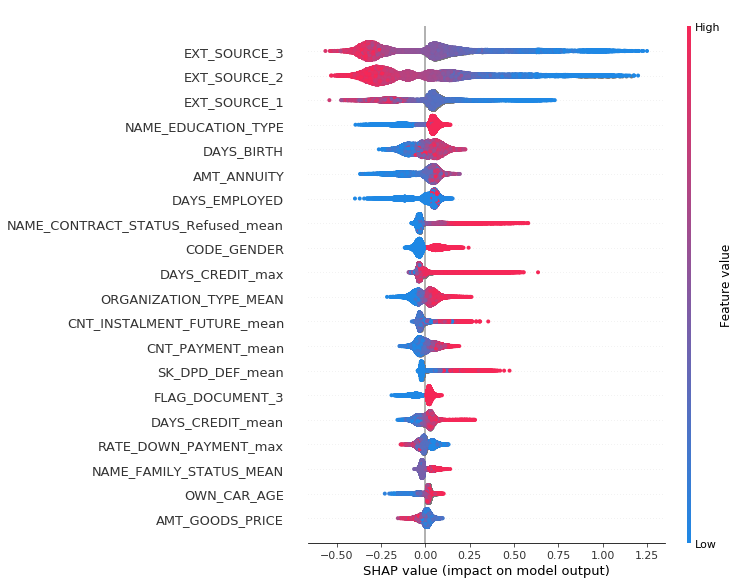

In [10]:
shap.summary_plot(shap_values, X_fit)

In [ ]:
DAYS_BIRTH , DAYS_ID_PUBLISH

In [139]:
feat_imp = feature_importances.groupby("feature").mean().sort_values("importance", ascending=False)

In [127]:
feature_importances.groupby("feature").mean().sort_values("importance", ascending=False)

,importance,fold
feature,,
i8,81.6,3.0
i12,72.2,3.0
i11,71.0,3.0
i17,61.0,3.0
i14,59.6,3.0
i10,58.6,3.0
i24,58.6,3.0
i3,58.2,3.0
i127,55.2,3.0
